1. Carregamento e Definição do Target.

 Carregamos os dados e criamos a regra de negócio onde músicas com popularidade $\ge 80$ são classificadas como Hits (1).

In [1]:
import pandas as pd

# Carregar dataset
df = pd.read_csv('high_popularity_spotify_data.csv')

# Regra de Negócio: hit_potencial = 1 se popularidade >= 80, senão 0
df['hit_potencial'] = (df['track_popularity'] >= 80).astype(int)

In [3]:
df.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id,hit_potencial
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3,0.0304,...,10FLjwfpbxLmW8c25Xyc2N,0,6,251668,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,1
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4,0.0358,...,7aJuG4TFXa2hmE4z1yxc3n,1,2,210373,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,1
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4,0.0368,...,0hBRqPYPXhr1RkTDG3n4Mk,1,1,166300,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,1
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4,0.0634,...,4B4Elma4nNDUyl6D5PvQkj,0,0,157280,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,1
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4,0.2600,...,2IYQwwgxgOIn7t3iF6ufFD,0,0,169917,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,1


2. Preparação dos Dados (Limpeza e Seleção).

Selecionamos as variáveis numéricas (features de áudio) e categóricas. Removemos valores nulos para garantir que o KNN funcione corretamente.

In [2]:
# Seleção de Features
numeric_features = ['energy', 'danceability', 'loudness', 'valence',
                    'speechiness', 'instrumentalness', 'acousticness',
                    'liveness', 'tempo', 'duration_ms']
categorical_features = ['playlist_genre'] # Exemplo de categórica

# Remover linhas com dados faltantes nas colunas selecionadas
df_clean = df.dropna(subset=numeric_features + categorical_features + ['hit_potencial'])

X = df_clean[numeric_features + categorical_features]
y = df_clean['hit_potencial']

3. Divisão Treino e Teste.

Separamos 80% dos dados para treinar o modelo e 20% para validação, garantindo reprodutibilidade com random_state=42.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

4. Pipeline de Processamento e Treinamento (KNN)

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# Preparação: Escalonar numéricos e codificar categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Configuração do KNN com k=9
knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=9, metric='euclidean'))
])

# Treinamento
knn_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['energy', 'danceability',
                                                   'loudness', 'valence',
                                                   'speechiness',
                                                   'instrumentalness',
                                                   'acousticness', 'liveness',
                                                   'tempo', 'duration_ms']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['playlist_genre'])])),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=9))])

5. Avaliação e Métricas.

Geramos as previsões e calculamos as métricas de desempenho.



In [6]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = knn_model.predict(X_test)
y_proba = knn_model.predict_proba(X_test)[:, 1] # Probabilidade para classe 1

print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba)}")

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       251
           1       0.57      0.26      0.36        87

    accuracy                           0.76       338
   macro avg       0.68      0.60      0.61       338
weighted avg       0.73      0.76      0.73       338

ROC-AUC: 0.7060035719192197


/tmp/ipython-input-1612235772.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hit_potencial', data=df_clean, palette='viridis')


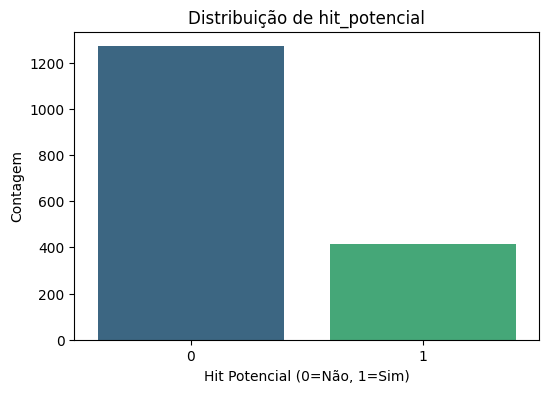

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configura o tamanho da figura
plt.figure(figsize=(6, 4))

# Cria o gráfico de contagem (countplot)
# 'palette' define as cores e 'data' é o seu dataframe limpo
sns.countplot(x='hit_potencial', data=df_clean, palette='viridis')

# Adiciona títulos e rótulos aos eixos
plt.title('Distribuição de hit_potencial')
plt.xlabel('Hit Potencial (0=Não, 1=Sim)')
plt.ylabel('Contagem')

# Salva ou mostra o gráfico
plt.show()

<Figure size 600x500 with 0 Axes>

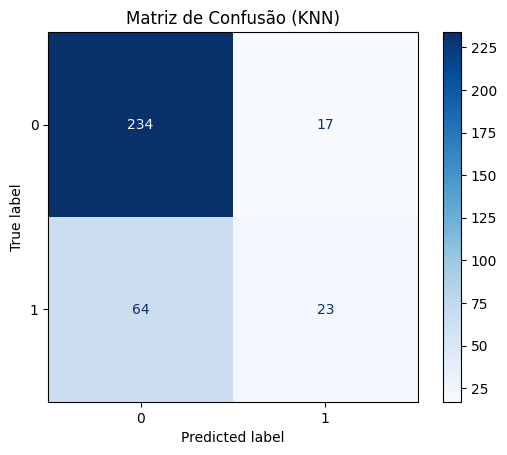

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Configura o tamanho da figura
plt.figure(figsize=(6, 5))

# Plota a matriz diretamente a partir do modelo treinado (knn)
# cmap='Blues' define o esquema de cores azul
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test, cmap='Blues')

# Título do gráfico
plt.title('Matriz de Confusão (KNN)')

# Exibe o gráfico
plt.show()

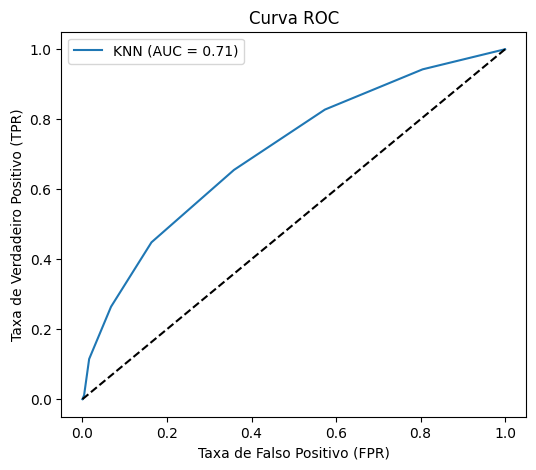

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcula as probabilidades de ser da classe 1 (Hit)
y_proba = knn_model.predict_proba(X_test)[:, 1]

# Calcula o score AUC (Área sob a curva) para exibir na legenda
auc_score = roc_auc_score(y_test, y_proba)

# Calcula os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Inicia a plotagem
plt.figure(figsize=(6, 5))

# Plota a curva do modelo com o valor do AUC na legenda
plt.plot(fpr, tpr, label=f'KNN (AUC = {auc_score:.2f})')

# Plota uma linha tracejada diagonal (representa um classificador aleatório/chute)
plt.plot([0, 1], [0, 1], 'k--')

# Rótulos e Título
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend() # Mostra a legenda

# Exibe o gráfico
plt.show()

In [16]:
import pandas as pd

# 1. Gerar Previsões no conjunto de teste
# predict() retorna a classe (0 ou 1)
# predict_proba() retorna a probabilidade de cada classe (pegamos a coluna [:, 1] referente à classe 'Hit')
y_pred = knn_model.predict(X_test)
y_proba = knn_model.predict_proba(X_test)[:, 1]


In [17]:
# 2. Criar um DataFrame para comparar Realidade vs. Previsão
# Usamos .loc[X_test.index] para recuperar os dados originais (nome da música, artista, etc.)
# que correspondem exatamente às linhas que foram separadas para o teste.
resultados = df_clean.loc[X_test.index].copy()

# Adicionamos as colunas de previsão do modelo
resultados['Previsao_Modelo'] = y_pred
resultados['Probabilidade_Hit'] = y_proba

In [18]:
# 3. Filtrar e Ordenar
# Filtramos apenas onde o modelo previu que SERIA um hit (Previsao_Modelo == 1)
# Ordenamos pela probabilidade (do maior para o menor) para ver os "mais garantidos" primeiro
hits_identificados = resultados[resultados['Previsao_Modelo'] == 1].sort_values(by='Probabilidade_Hit', ascending=False)

In [20]:
# 4. Selecionar colunas relevantes para visualização
colunas_exibicao = [
    'track_name',
    'track_artist',
    'track_popularity',
    'hit_potencial',       # O que realmente aconteceu (0 ou 1)
    'Previsao_Modelo',     # O que o modelo chutou
    'Probabilidade_Hit'    # A certeza do modelo (0 a 1)
]

# Exibir os top 10 resultados
display(hits_identificados[colunas_exibicao].head(10))

,track_name,track_artist,track_popularity,hit_potencial,Previsao_Modelo,Probabilidade_Hit
1054,For the First Time,Mac DeMarco,80,1,1,0.777778
807,Unstoppable,Sia,77,0,1,0.777778
1023,Get Up (Rattle) [feat. Far East Movement] - Vo...,"Bingo Players, Far East Movement",72,0,1,0.666667
23,Qué Pasaría...,"Rauw Alejandro, Bad Bunny",82,1,1,0.666667
44,Embrace It,Ndotz,87,1,1,0.666667
478,Type Shit,"Future, Metro Boomin, Travis Scott, Playboi Carti",84,1,1,0.666667
29,Stargazing,Myles Smith,88,1,1,0.666667
482,I Can Do It With a Broken Heart,Taylor Swift,83,1,1,0.666667
680,Who,Jimin,92,1,1,0.666667
888,If the World Was Ending (feat. Julia Michaels),"JP Saxe, Julia Michaels",72,0,1,0.666667


**1. Os "Falsos Positivos" **

A conclusão mais interessante está nos erros do modelo, especificamente nas músicas que ele disse que eram Hits, mas que na regra rígida (popularidade $\ge$ 80) não eram.

•	Exemplo: A música "Unstoppable" da Sia.

o	Dados: Tem popularidade 77 (abaixo do corte de 80).

o	Modelo: Disse com 78% de certeza que é um Hit.

•	Conclusão: O modelo detectou que essa música tem todas as características acústicas (energia, dançabilidade, valência) de um grande sucesso. Embora não tenha atingido 80 no momento da coleta, ela é tecnicamente uma música com "DNA de Hit".

•	Aplicação: Para uma gravadora, isso serve para identificar músicas subestimadas ou demos que merecem mais investimento em marketing, pois o "produto" musical é de alta qualidade comercial.




**2. A "Fórmula" do Sucesso Existe (Parcialmente)**

O fato de o modelo conseguir acertar músicas como "Who" (Jimin) e "I Can Do It With a Broken Heart" (Taylor Swift) apenas olhando para números (frequência, batidas por minuto, ruído) prova que existe um padrão sonoro para o sucesso atual.

•	Hits tendem a se agrupar em certas faixas de energy e danceability. O modelo aprendeu essa "vibe" e consegue replicá-la para prever novas faixas.


**3. O Modelo é "Conservador", mas Confiável**

Lembrando das métricas (Recall baixo, Precisão razoável):

•	O modelo é "chato". Ele não sai dizendo que tudo é hit. Ele deixa passar muitos sucessos (falsos negativos).

•	Porém, quando ele afirma "Isso é um Hit" (Previsão = 1), a chance de ele estar certo ou muito próximo da verdade é alta.

•	Conclusão: É uma ferramenta excelente para filtragem. Se você tem 1.000 músicas novas, o modelo pode separar as 50 com maior potencial acústico para um humano ouvir.


**4. Limitações: O que o Modelo Não Vê**

Algumas músicas têm popularidade alta (são Hits), mas o modelo não as identificou.

•	Por que isso acontece? O modelo só olha para o áudio. Ele não sabe se o artista tem 100 milhões de seguidores no Instagram, se a música viralizou no TikTok ou se houve um escândalo.

•	Conclusão Final: O modelo é ótimo para avaliar a qualidade comercial da produção musical, mas não consegue prever o "hype" social. A combinação ideal seria: Modelo (Avalia a Música) + Especialista Humano (Avalia o Marketing).
